In [68]:
import datetime
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras
import sklearn
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import sys
from keras import backend as K
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Activation, TimeDistributed, Dropout, Lambda, RepeatVector, Input, Reshape, Concatenate, Dot
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
#from keras.utils import plot_model


In [6]:
from google.colab import drive

drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/NN_final_project/stock/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
tickers = ['SPY','QQQ','AMZN','IWM','AAPL','AMGN','CVX','DE','JNJ','KO','OXY','WMT']
ticker = 'AMZN'

The following function performs data preprocessing for the deep learning model. It requires three inputs.

Data: the information of stock we have.
time_step (n): the size of the input of the lstm model. The lstm will require stock prices n days piror to make an output.
output (m): the lstm will generate m-days ahead forcast of this particular company.

In [19]:
filename = ticker+'_train.csv'

train = pd.read_csv(path+filename)

filename = ticker+'_val.csv'

val = pd.read_csv(path+filename)

filename = ticker+'_test.csv'

test = pd.read_csv(path+filename)

In [31]:
test

,Date,Volume,Adj Close,rsi,bond_yield
0,2022-01-24,7781200,2890.879883,16.738087,1.735
1,2022-01-25,4541200,2799.719971,14.239024,1.783
2,2022-01-26,4780100,2777.449951,13.700853,1.848
3,2022-01-27,3875800,2792.750000,16.048461,1.807
4,2022-01-28,3719600,2879.560059,28.013925,1.782
5,2022-01-31,3915400,2991.469971,39.905030,1.782
6,2022-02-01,2961000,3023.870117,42.848531,1.800
7,2022-02-02,4366500,3012.250000,42.052975,1.766
8,2022-02-03,11276600,2776.909912,29.931933,1.827
9,2022-02-04,12672800,3152.790039,53.155895,1.930


In [32]:
sc = MinMaxScaler(feature_range = (0, 1))
sc2 = MinMaxScaler(feature_range = (0, 1))

training_set_scaled = sc.fit_transform(train[['Volume','Adj Close','rsi','bond_yield']].values)
y_scaled = sc2.fit_transform(train['Adj Close'].values.reshape(-1,1))

time_step = 7
output = 7

def transform_data(data,time_step,output,sc,sc2):
  training_set_scaled = sc.transform(data[['Volume','Adj Close','rsi','bond_yield']].values)
  y_scaled = sc2.transform(data['Adj Close'].values.reshape(-1,1))
  n = time_step
  m = output
  num_training_samples = np.array(data).shape[0]

  X_train = []
  y_train = []
  for i in range(n, num_training_samples):
    X_train.append(training_set_scaled[i-n:i-m+1, :])
    y_train.append(training_set_scaled[i-m+1:i+1, 1])
    
  X_train, y_train = np.array(X_train), np.array(y_train)
  y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

  print("the shape of X:", X_train.shape)
  print("the shape of y:", y_train.shape)

  return X_train,y_train

In [33]:
X_train,y_train = transform_data(train,time_step,output,sc,sc2)
X_val,y_val = transform_data(val,time_step,output,sc,sc2)
X_test,y_test = transform_data(test,time_step,output,sc,sc2)

the shape of X: (3163, 1, 4)
the shape of y: (3163, 7, 1)
the shape of X: (63, 1, 4)
the shape of y: (63, 7, 1)
the shape of X: (41, 1, 4)
the shape of y: (41, 7, 1)


In [61]:
n = time_step
m = output

model = Sequential()
model.add(LSTM(units = 512, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 256, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 32))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = m))

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose = 1, 
                               patience = 10,
                               restore_best_weights = False
                               )

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32,callbacks = [early_stopping],validation_data=(X_val, y_val))

Epoch 1/100
99/99 [==============================] - 16s 64ms/step - loss: 0.0518 - val_loss: 0.0017
Epoch 2/100
99/99 [==============================] - 4s 39ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 3/100
99/99 [==============================] - 4s 39ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 4/100
99/99 [==============================] - 4s 38ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 5/100
99/99 [==============================] - 4s 39ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/100
99/99 [==============================] - 4s 41ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 7/100
99/99 [==============================] - 4s 45ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 8/100
99/99 [==============================] - 4s 41ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 9/100
99/99 [==============================] - 4s 39ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 10/100
99/99 [==============================] - 4s 41ms/step - loss: 0.0020 - val_loss: 0.003

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1, 512)            1058816   
                                                                 
 dropout_5 (Dropout)         (None, 1, 512)            0         
                                                                 
 lstm_6 (LSTM)               (None, 1, 256)            787456    
                                                                 
 dropout_6 (Dropout)         (None, 1, 256)            0         
                                                                 
 lstm_7 (LSTM)               (None, 1, 128)            197120    
                                                                 
 dropout_7 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 64)            

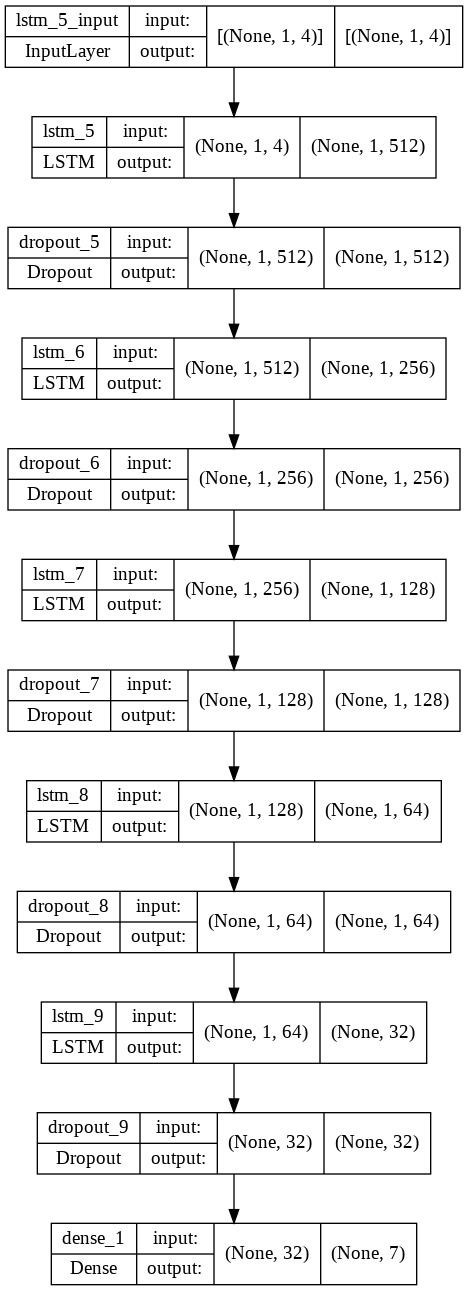

In [75]:
#Evaluate performance 
model.summary()

#model.save("model_lstm_layer2.h5")
#print("Model saved.")

loss = model.evaluate(X_test, y_test, batch_size = 32)

# early_stopping.stopped_epoch returns 0 if training didn't stop early. 
print('Training stopped after',early_stopping.stopped_epoch,'epochs.')

tf.keras.utils.plot_model(model, show_shapes=True)



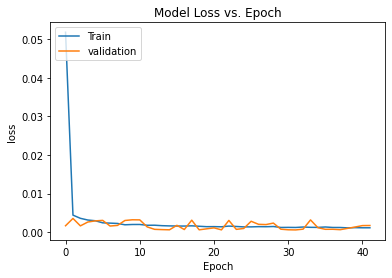

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

In [64]:
test_index = test['Date']



def evaluate_model(X_test,m):
  predicted_stock_price = model.predict(X_test)
  for i in range(m):
    
    title = ticker + ' Stock Price Prediction'
    y_test_i = sc2.inverse_transform(y_test[:,i,0].reshape(-1,1))
    dayi = sc2.inverse_transform(predicted_stock_price[:,i].reshape(-1,1))

    plot_d = {'actual price': y_test_i.reshape(-1,), 'pred_lstm': dayi.reshape(-1,)}
    plot_df = pd.DataFrame(plot_d)
    plot_df.index = test_index[m:]

    mse = sklearn.metrics.mean_squared_error(y_test_i, dayi)
    rmse = math.sqrt(mse)
    print("rmse of day ", i+1, " forecast is : ", rmse)
    # Visualising the results
    #plt.plot(dataset_test.index,y_test_i, color = 'red', label = 'Real Stock Price')
    #plt.plot(dataset_test.index,y_test_i, color = 'red', label = 'Real Stock Price')
    plt.plot(plot_df['actual price'], color = 'red', label = 'Real Stock Price')
    #plt.plot(dataset_test.index,dayi, color = 'blue', label = 'Predicted Stock Price')
    plt.plot(plot_df['pred_lstm'], color = 'blue', label = 'Predicted Stock Price')
    #plt.xticks(np.arange(0,num_test_samples,400))
    plt.title(title)
    plt.xlabel('Time')
    ylab = ticker + ' Stock Price'
    plt.ylabel(ylab)
    plt.legend()
    plt.show()

    if i == 0:
      y_actual = y_test_i
      y_pred = dayi
    
  return y_actual,y_pred

rmse of day  1  forecast is :  115.31445751533852


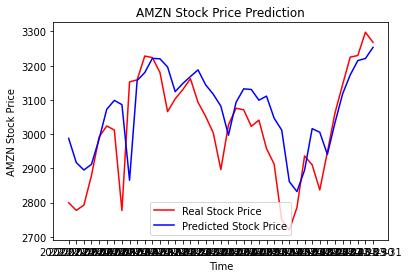

rmse of day  2  forecast is :  136.65795342577945


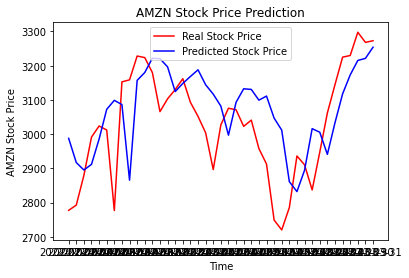

rmse of day  3  forecast is :  153.50916125543097


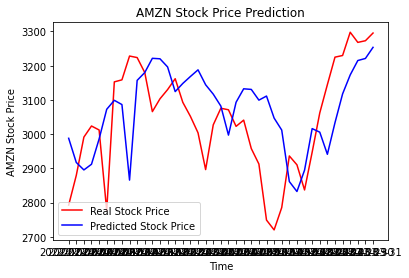

rmse of day  4  forecast is :  160.95014010674447


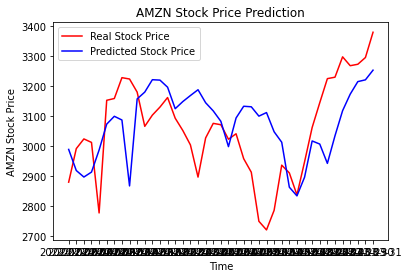

rmse of day  5  forecast is :  171.90818722010331


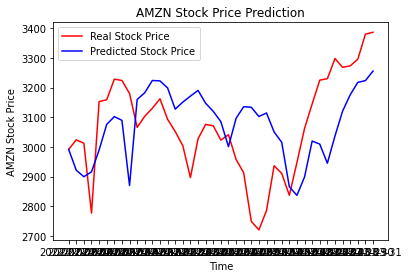

rmse of day  6  forecast is :  184.63942918317068


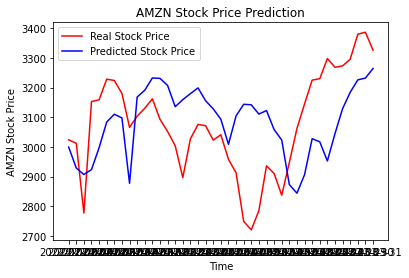

rmse of day  7  forecast is :  202.44936621685653


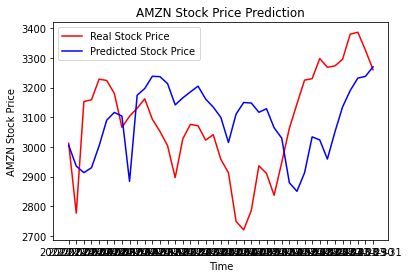

,time,actual price,pred_lstm
7,2022-02-02,2799.719971,2987.755127
8,2022-02-03,2777.449951,2917.143555
9,2022-02-04,2792.750000,2895.307617
10,2022-02-07,2879.560059,2911.875488
11,2022-02-08,2991.469971,2985.734863
12,2022-02-09,3023.870117,3072.489990
13,2022-02-10,3012.250000,3098.715088
14,2022-02-11,2776.909912,3086.281738
15,2022-02-14,3152.790039,2865.597900
16,2022-02-15,3158.709961,3156.980225


In [65]:
y_actual,y_pred = evaluate_model(X_test,m)

d = {'time':test_index[m:],'actual price': y_actual.reshape(-1,), 'pred_lstm': y_pred.reshape(-1,)}
df = pd.DataFrame(d)
df

In [76]:
def seq2seq(feature_len=1,after_day=5, time_step = 60):
    '''
    Encoder:
    X = Input sequence
    C = LSTM(X); The context vector
    Decoder:
    y(t) = LSTM(s(t-1), y(t-1)); where s is the hidden state of the LSTM(h and c)
    y(0) = LSTM(s0, C); C is the context vector from the encoder.
    '''
    
    time_step = time_step - after_day + 1
    input_shape = (time_step,feature_len)

    # Encoder
    #encoder_inputs = Input(shape=input_shape) # (timesteps, feature)
    #encoder = LSTM(units=100, return_state=True,  name='encoder')
    #encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    #states = [state_h, state_c]

    #Encoder Multiple layers
    encoder_inputs=Input(shape=input_shape) # (timesteps, feature)
    encoder_lstm=LSTM(units=100, return_state=True,return_sequences=True)(encoder_inputs)
    encoder_lstm=LSTM(units=100, return_state=True)(encoder_lstm)
    encoder_outputs, state_h, state_c=encoder_lstm
    states = [state_h, state_c]

    # Decoder
    reshapor = Reshape((1, 100), name='reshapor')
    decoder = LSTM(units=100, return_sequences=True, return_state=True, name='decoder')

    # Densor
    #tdensor = TimeDistributed(Dense(units=200, activation='linear', name='time_densor'))
    densor_output = Dense(units=1, activation='linear', name='output')
    

    inputs = reshapor(encoder_outputs)
    #inputs = tdensor(inputs)
    all_outputs = []

    for _ in range(after_day):
        outputs, h, c = decoder(inputs, initial_state=states)

        #inputs = tdensor(outputs)
        inputs = outputs
        states = [state_h, state_c]

        outputs = densor_output(outputs)
        all_outputs.append(outputs)

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

    return model

In [77]:
batch_size = 32
after_day = m
time_step = n

model = seq2seq(feature_len=4,after_day=after_day, time_step = time_step)


early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose = 1, 
                               patience = 9,
                               restore_best_weights = False
                               )

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = model.fit(X_train, y_train, epochs = 100, batch_size = batch_size,callbacks = [early_stopping],validation_data=(X_val, y_val))

Epoch 1/100
99/99 [==============================] - 25s 62ms/step - loss: 0.0178 - val_loss: 0.0016
Epoch 2/100
99/99 [==============================] - 2s 20ms/step - loss: 2.5491e-04 - val_loss: 7.5224e-04
Epoch 3/100
99/99 [==============================] - 2s 22ms/step - loss: 2.2132e-04 - val_loss: 7.6005e-04
Epoch 4/100
99/99 [==============================] - 2s 19ms/step - loss: 1.9520e-04 - val_loss: 7.5123e-04
Epoch 5/100
99/99 [==============================] - 2s 18ms/step - loss: 2.0606e-04 - val_loss: 9.3847e-04
Epoch 6/100
99/99 [==============================] - 2s 19ms/step - loss: 1.9620e-04 - val_loss: 8.7866e-04
Epoch 7/100
99/99 [==============================] - 2s 19ms/step - loss: 2.0341e-04 - val_loss: 7.4158e-04
Epoch 8/100
99/99 [==============================] - 2s 19ms/step - loss: 2.0791e-04 - val_loss: 9.4417e-04
Epoch 9/100
99/99 [==============================] - 2s 19ms/step - loss: 1.9802e-04 - val_loss: 7.0220e-04
Epoch 10/100
99/99 [===============

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 4)]       0           []                               
                                                                                                  
 lstm_10 (LSTM)                 [(None, 1, 100),     42000       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_11 (LSTM)                 [(None, 100),        80400       ['lstm_10[0][0]',                
                                 (None, 100),                     'lstm_10[0][1]',            

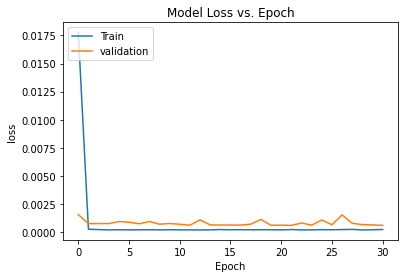

rmse of day  1  forecast is :  101.48343722383017


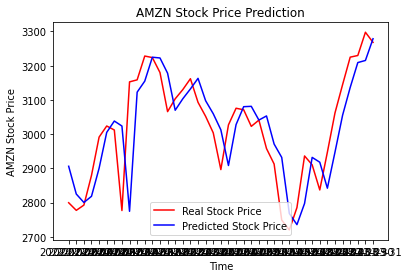

rmse of day  2  forecast is :  135.24905486011176


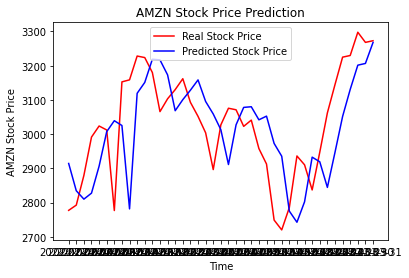

rmse of day  3  forecast is :  160.28442964987684


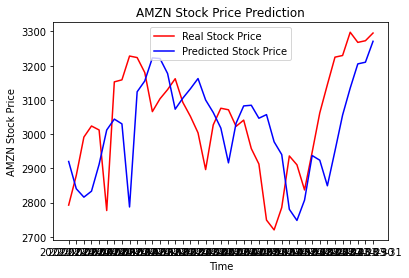

rmse of day  4  forecast is :  172.86359141412646


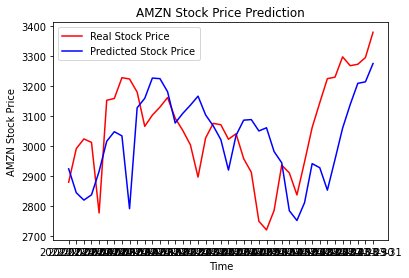

rmse of day  5  forecast is :  187.7046226547375


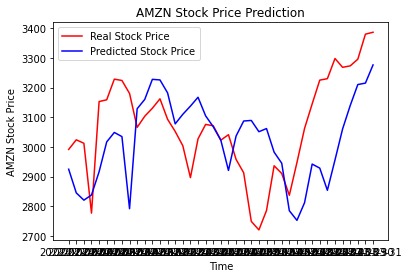

rmse of day  6  forecast is :  202.59936893346804


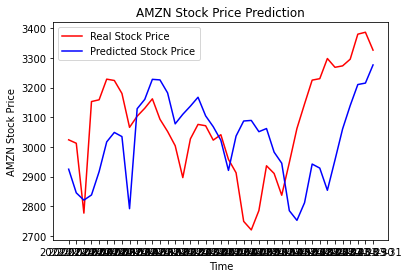

rmse of day  7  forecast is :  223.10225222670303


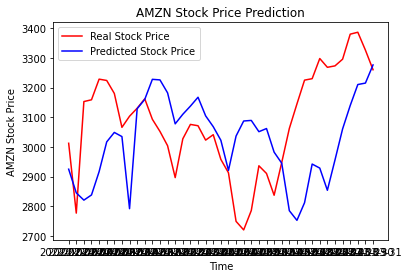

,time,actual price,pred_lstm
7,2022-02-02,2799.719971,2906.244873
8,2022-02-03,2777.449951,2825.117676
9,2022-02-04,2792.750000,2800.488281
10,2022-02-07,2879.560059,2818.497559
11,2022-02-08,2991.469971,2900.541016
12,2022-02-09,3023.870117,3005.223877
13,2022-02-10,3012.250000,3038.394287
14,2022-02-11,2776.909912,3023.769287
15,2022-02-14,3152.790039,2774.686035
16,2022-02-15,3158.709961,3122.748535


In [78]:
#Evaluate performance 
model.summary()

#model.save("model_lstm_layer2.h5")
#print("Model saved.")

loss = model.evaluate(X_test, y_test, batch_size = 32)

# early_stopping.stopped_epoch returns 0 if training didn't stop early. 
print('Training stopped after',early_stopping.stopped_epoch,'epochs.')

tf.keras.utils.plot_model(model, show_shapes=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

y_actual,y_pred = evaluate_model(X_test,m)

d = {'time':test_index[m:],'actual price': y_actual.reshape(-1,), 'pred_lstm': y_pred.reshape(-1,)}
df = pd.DataFrame(d)
df

In [79]:
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')


def one_step_attention(a, s_prev, repeator, concatenator, densor, activator, dotor):
    s_prev = repeator(s_prev)
    concat = concatenator([s_prev, a])
    e = densor(concat)
    alphas = activator(e)
    context =  dotor([alphas, a])

    return context

def seq2seq_attention(feature_len=1, after_day=1, time_step=20):

    time_step = time_step-after_day+1
    input_shape = (time_step,feature_len)
    # Define the inputs of your model with a shape (Tx, feature)
    X = Input(shape=input_shape)

    # Initialize empty list of outputs
    all_outputs = []

    # Encoder: pre-attention LSTM
    encoder = LSTM(units=100, return_state=True, return_sequences=True, name='encoder')
    # Decoder: post-attention LSTM
    decoder = LSTM(units=100, return_state=True, name='decoder')
    # Output
    decoder_output = Dense(units=1, activation='linear', name='output')
    model_output = Reshape((1, 1))

    # Attention
    repeator = RepeatVector(time_step)
    concatenator = Concatenate(axis=-1)
    densor = Dense(1, activation = "relu")
    activator = Activation(softmax, name='attention_weights')
    dotor =  Dot(axes = 1)

    encoder_outputs, s, c = encoder(X)

    for t in range(after_day):
        context = one_step_attention(encoder_outputs, s, repeator, concatenator, densor, activator, dotor)

        a, s, c = decoder(context, initial_state=[s, c])

        outputs = decoder_output(a)
        outputs = model_output(outputs)
        all_outputs.append(outputs)

    all_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(inputs=X, outputs=all_outputs)

    return model

batch_size = 32

model = seq2seq_attention(feature_len=4, after_day=after_day, time_step=time_step)

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose = 1, 
                               patience = 9,
                               restore_best_weights = False
                               )

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = model.fit(X_train, y_train, epochs = 100, batch_size = batch_size,callbacks = [early_stopping],validation_data=(X_val, y_val))

Epoch 1/100
99/99 [==============================] - 22s 54ms/step - loss: 0.0187 - val_loss: 0.0107
Epoch 2/100
99/99 [==============================] - 2s 17ms/step - loss: 8.7430e-04 - val_loss: 0.0021
Epoch 3/100
99/99 [==============================] - 2s 17ms/step - loss: 3.6774e-04 - val_loss: 0.0011
Epoch 4/100
99/99 [==============================] - 2s 17ms/step - loss: 2.7249e-04 - val_loss: 9.2517e-04
Epoch 5/100
99/99 [==============================] - 2s 18ms/step - loss: 2.4270e-04 - val_loss: 7.9290e-04
Epoch 6/100
99/99 [==============================] - 2s 17ms/step - loss: 2.2929e-04 - val_loss: 9.9434e-04
Epoch 7/100
99/99 [==============================] - 2s 17ms/step - loss: 2.3224e-04 - val_loss: 7.3359e-04
Epoch 8/100
99/99 [==============================] - 2s 17ms/step - loss: 2.1147e-04 - val_loss: 7.4445e-04
Epoch 9/100
99/99 [==============================] - 2s 17ms/step - loss: 2.1104e-04 - val_loss: 8.1143e-04
Epoch 10/100
99/99 [=======================

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 4)]       0           []                               
                                                                                                  
 encoder (LSTM)                 [(None, 1, 100),     42000       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 1, 100)       0           ['encoder[0][1]',                
                                                                  'decoder[0][1]',          

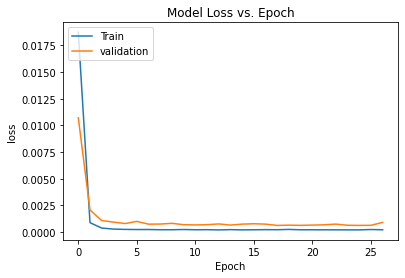

rmse of day  1  forecast is :  102.96580468184773


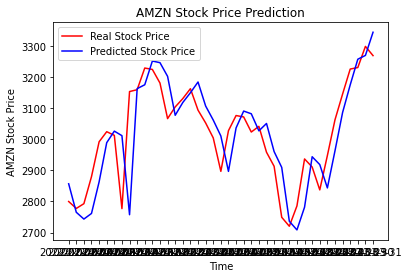

rmse of day  2  forecast is :  145.4729755807595


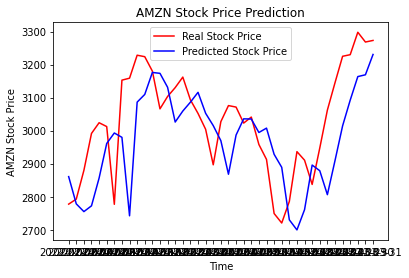

rmse of day  3  forecast is :  177.14480654345033


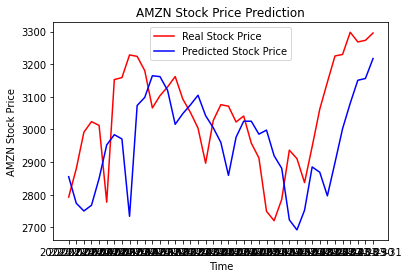

rmse of day  4  forecast is :  197.37409671314524


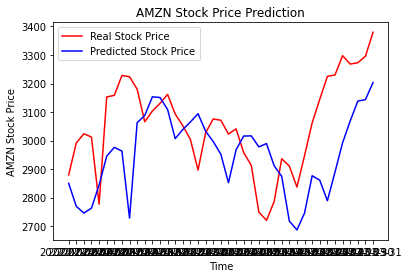

rmse of day  5  forecast is :  215.49225772787295


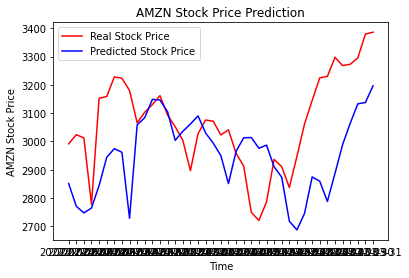

rmse of day  6  forecast is :  230.94029321273075


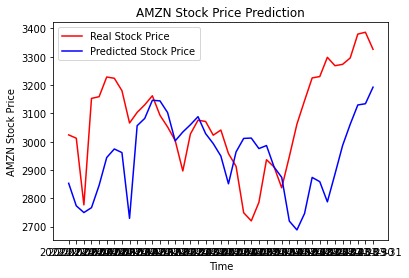

rmse of day  7  forecast is :  250.35285246650983


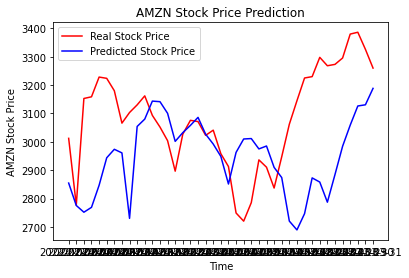

,time,actual price,pred_lstm
7,2022-02-02,2799.719971,2856.609131
8,2022-02-03,2777.449951,2765.177734
9,2022-02-04,2792.750000,2743.338623
10,2022-02-07,2879.560059,2761.380859
11,2022-02-08,2991.469971,2862.654053
12,2022-02-09,3023.870117,2988.623535
13,2022-02-10,3012.250000,3025.709229
14,2022-02-11,2776.909912,3011.135254
15,2022-02-14,3152.790039,2757.302002
16,2022-02-15,3158.709961,3162.093750


In [80]:
#Evaluate performance 
model.summary()

#model.save("model_lstm_layer2.h5")
#print("Model saved.")

loss = model.evaluate(X_test, y_test, batch_size = 32)

# early_stopping.stopped_epoch returns 0 if training didn't stop early. 
print('Training stopped after',early_stopping.stopped_epoch,'epochs.')

tf.keras.utils.plot_model(model, show_shapes=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

y_actual,y_pred = evaluate_model(X_test,m)

d = {'time':test_index[m:],'actual price': y_actual.reshape(-1,), 'pred_lstm': y_pred.reshape(-1,)}
df = pd.DataFrame(d)
df